# Churn Prediciton

* Load data & packages for model building 
* preprocessing and missing value imputaion
* selecting features and building the model

In [45]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [46]:
data=pd.read_csv("churn_prediction.csv")
data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


In [47]:
data.shape

(28382, 21)

<AxesSubplot: >

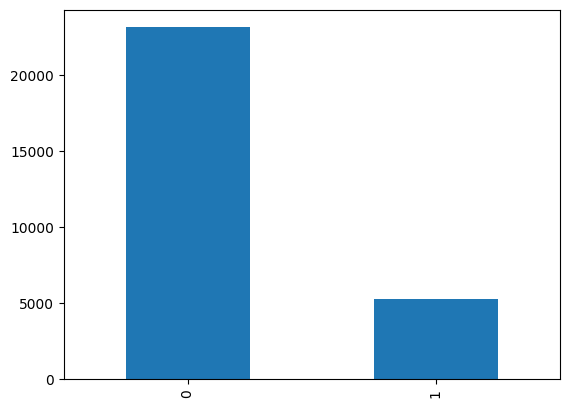

In [48]:
data['churn'].value_counts()
data['churn'].value_counts(normalize=True)
data['churn'].value_counts().plot.bar()

<AxesSubplot: title={'center': 'dependents'}>

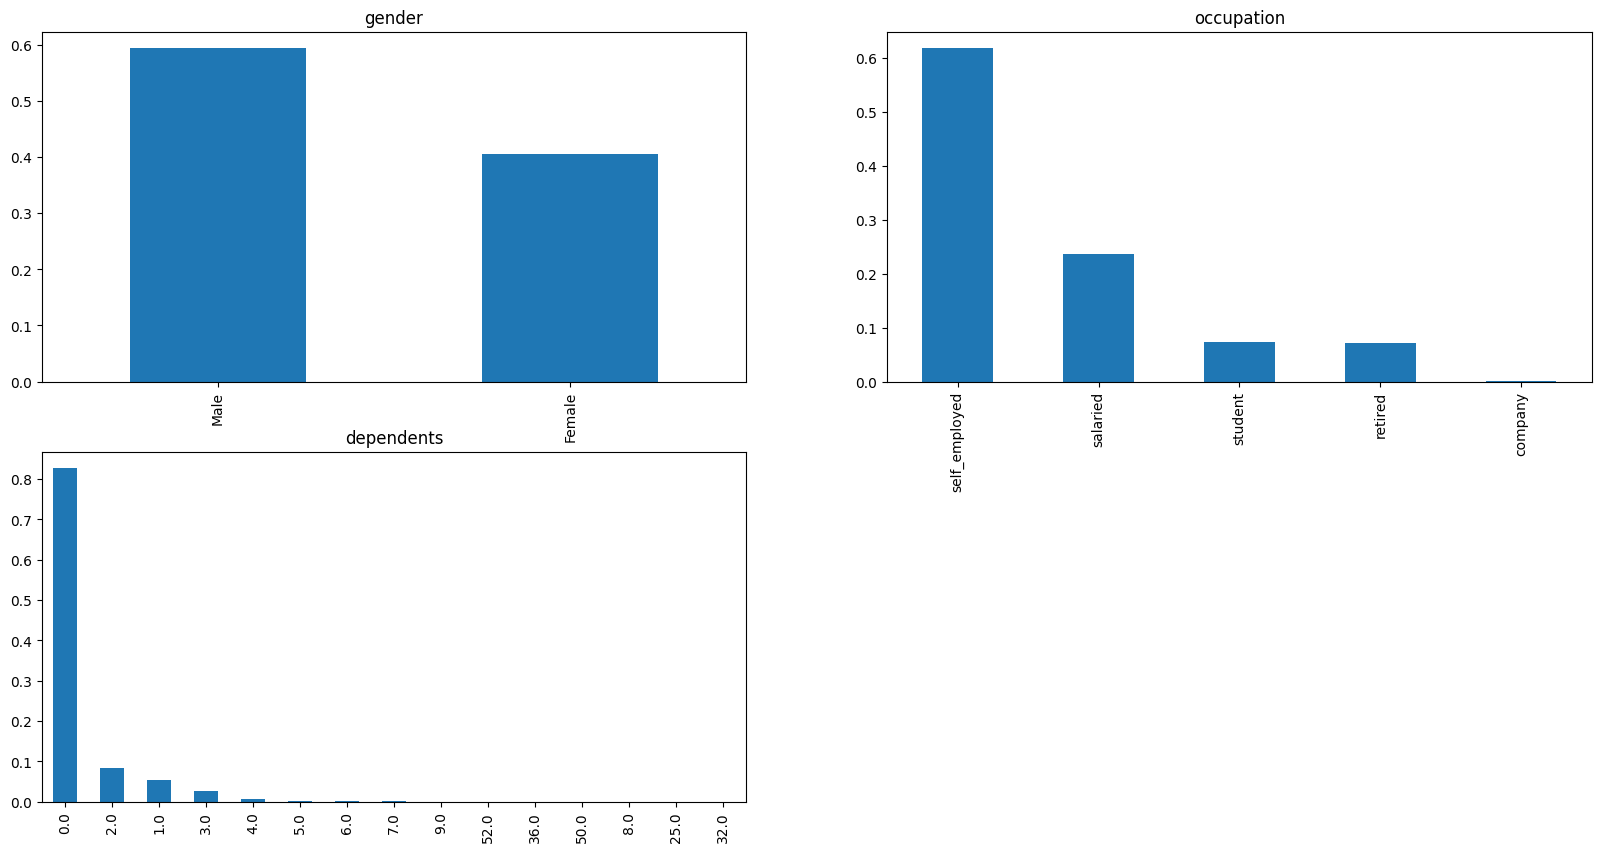

In [51]:
plt.figure(1)
plt.subplot(221)
data['gender'].value_counts(normalize=True).plot.bar(figsize=(20,10),title="gender")
plt.subplot(222)
data['occupation'].value_counts(normalize=True).plot.bar(figsize=(20,10),title="occupation")
plt.subplot(223)
data['dependents'].value_counts(normalize=True).plot.bar(figsize=(20,10),title="dependents")

<b>We can infer few things from above plots:</b>

<i>1.Around 60% applicants are male.</i>

<i>2.Around 60% applicants are self employed.</i>

<i>3.Most of applicants have no dependents.</i>

<AxesSubplot: >

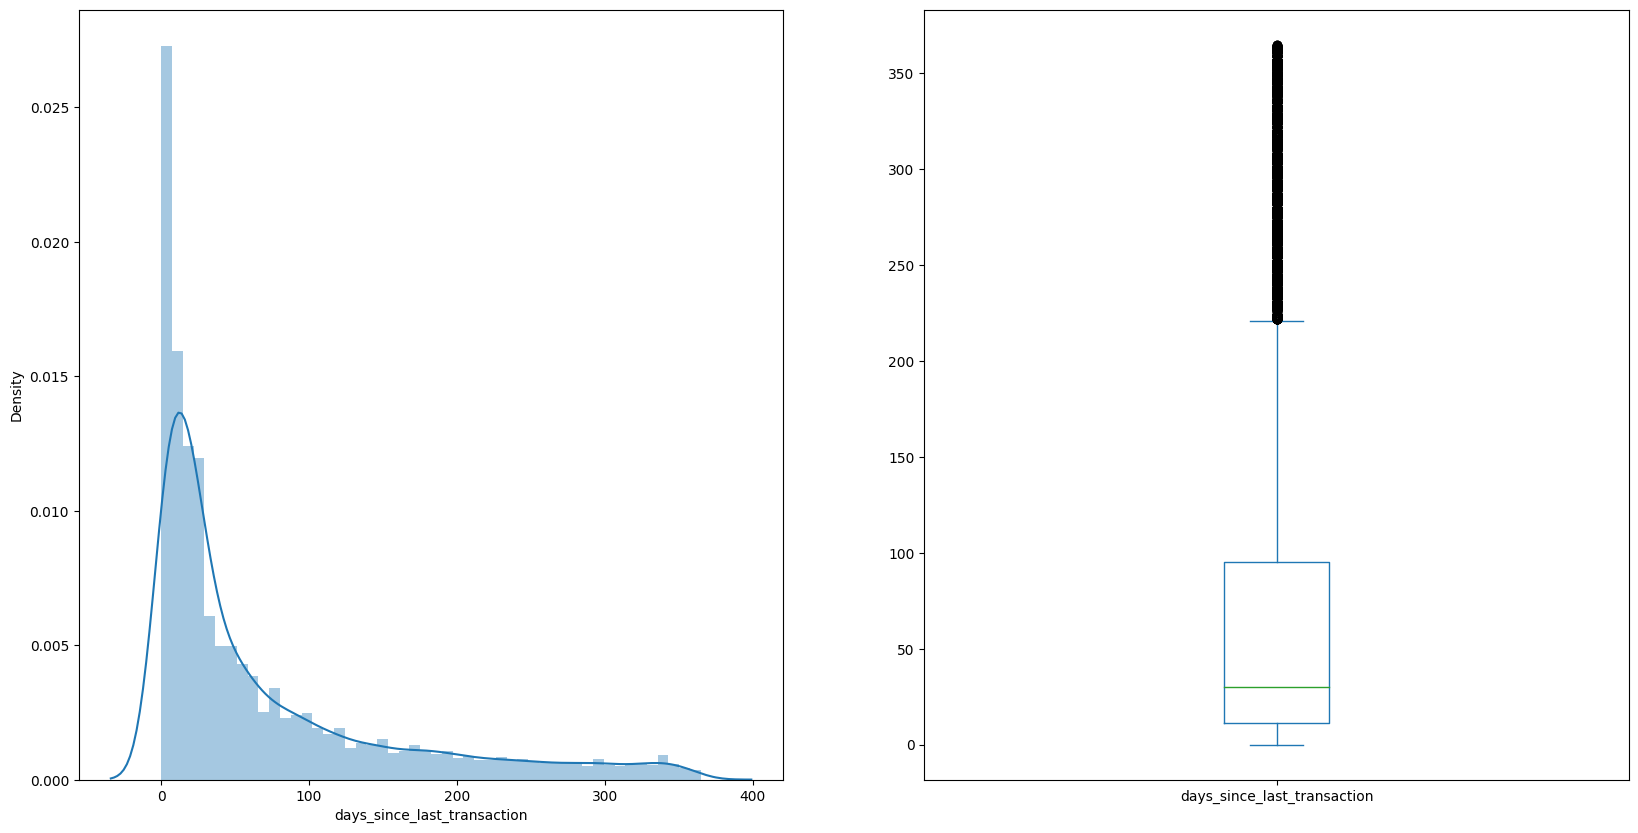

In [52]:
import seaborn as sns

plt.figure(1)
plt.subplot(121)
sns.distplot(data['days_since_last_transaction']);
plt.subplot(122)
data['days_since_last_transaction'].plot.box(figsize=(20,10))

**Here the distribution is rightskewed hence to reduce skewness we will apply log transformations & there are many outliers in the in this column.

## Missing Values

In [4]:
data.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

The result of function shows us there quite few missing values in column gender,dependents,city, days_since_last_transaction.Let us go through each one them and find appropriate missing value imputation.


In [5]:
data["gender"].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

<b>Gender</b>

There is good mix of values and argubaly We cannot fill this with any one of the value.So we assign -1 for alll the missing values.

In [6]:
dict_gender={"Male" : 1, "Female": 0}
data.replace({"gender":dict_gender},inplace=True)

data["gender"]=data["gender"].fillna(-1)

<b>Dependents,city,occupation</b>

In [7]:
data["dependents"].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
9.0         1
52.0        1
36.0        1
50.0        1
8.0         1
25.0        1
32.0        1
Name: dependents, dtype: int64

In [8]:
data["occupation"].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [9]:
data["city"].value_counts()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
748.0        1
1099.0       1
108.0        1
655.0        1
723.0        1
Name: city, Length: 1604, dtype: int64

<i><b>We will fill this missing values with mode as this is sort of ordinal varible.</b></i>

In [10]:
data["city"]=data["city"].fillna(1020)

In [11]:
data["occupation"]=data["occupation"].fillna("self_employed")

In [12]:
data["dependents"]=data["dependents"].fillna(0)

<b>Days since last transaction</b>

A fair assumption can be made on this columns as it is number of transaction made since one year, we can substitute the missing value greater than one year say 999 , which represents customer is inactive

In [13]:
data["days_since_last_transaction"]=data["days_since_last_transaction"].fillna(999)

# Preprocessing

<b>since we are applying the linear models we need to scale data & all features in numerically strict.</b>
Now, we remember that there are a lot of outliers in the dataset especially when it comes to previous and current balance features. Also, the distributions are skewed for these features if you recall from the EDA. We will take 2 steps to deal with that here:
* Log Transformation
* Standard Scaler

In [19]:
data=pd.concat([data,pd.get_dummies(data['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)
data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,1,3135,66,1.0,0.0,self_employed,187.0,2,755,224.0,...,0.20,0.20,1458.71,1458.71,0,0,0,0,1,0
1,2,310,35,1.0,0.0,self_employed,1020.0,2,3214,60.0,...,5486.27,100.56,6496.78,8787.61,0,0,0,0,1,0
2,4,2356,31,1.0,0.0,salaried,146.0,2,41,999.0,...,6046.73,259.23,5006.28,5070.14,0,0,0,1,0,0
3,5,478,90,-1.0,0.0,self_employed,1020.0,2,582,147.0,...,0.47,2143.33,2291.91,1669.79,1,0,0,0,1,0
4,6,2531,42,1.0,2.0,self_employed,1494.0,3,388,58.0,...,588.62,1538.06,1157.15,1677.16,1,0,0,0,1,0


In [20]:
num_cols = ['current_balance','previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']

for i in num_cols:
    data[i] = np.log(data[i] + 17000)    

In [16]:
from sklearn.preprocessing import StandardScaler

std=StandardScaler()
scaled=std.fit_transform(data[num_cols])
scaled=pd.DataFrame(scaled,columns=num_cols)

In [17]:
df_copy=data.copy()
data=data.drop(columns=num_cols,axis=1)

In [18]:
data = data.merge(scaled,left_index=True,right_index=True,how = "left")
data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,1,3135,66,1.0,0.0,self_employed,187.0,2,755,224.0,...,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,2,310,35,1.0,0.0,self_employed,1020.0,2,3214,60.0,...,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,4,2356,31,1.0,0.0,salaried,146.0,2,41,999.0,...,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,5,478,90,-1.0,0.0,self_employed,1020.0,2,582,147.0,...,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,6,2531,42,1.0,2.0,self_employed,1494.0,3,388,58.0,...,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732


## Model Building and Evaluation Metrics
Since this is a binary classification problem, we could use the following 2 popular metrics:

1. Recall
2. Area under the Receiver operating characteristic curve

Now, we are looking at the recall value here because a customer falsely marked as churn would not be as bad as a customer who was not detected as a churning customer and appropriate measures were not taken by the bank to stop him/her from churning

The ROC AUC is the area under the curve when plotting the (normalized) true positive rate (x-axis) and the false positive rate (y-axis).

Our main metric here would be Recall values, while AUC ROC Score would take care of how well predicted probabilites are able to differentiate between the 2 classes.

In [ ]:
y_all = data.churn
data = data.drop(['churn','customer_id','occupation'],axis = 1)

In [20]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [21]:
df_baseline = data[baseline_cols]

In [22]:
from sklearn.model_selection import train_test_split
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=11, stratify = y_all)

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

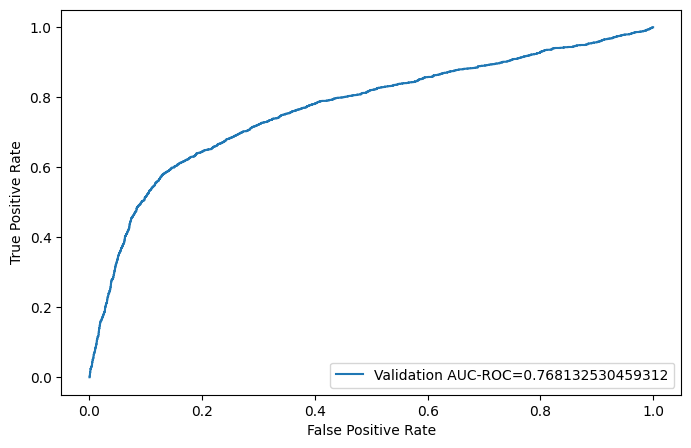

In [24]:
from sklearn.metrics import roc_curve,recall_score,precision_score,roc_auc_score,accuracy_score

fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(8,5)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc))

plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [25]:
pred_val = model.predict(xtest)
y_pred=np.where(pred_val>0.5,1,0)

In [26]:
# Recall Score
recall_score(ytest,pred_val)

0.11580148317170565

In [27]:
accuracy_score(ytest,y_pred)

0.8240143748018179

## Cross Validation

In [28]:
from sklearn.model_selection import StratifiedKFold

def cv_score(ml_model,rstate=15,thres=0.5,cols=data.columns):
    i=1
    cv_scores=[]
    df1=data.copy()
    df1=data[cols]
    
    kf=StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y_all.loc[df_index],y_all.loc[test_index]
        
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
        
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        pred_val=pp
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        accuracy=accuracy_score(yvl,pred_val)
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f},Acuuracy Score: {:.4f} ".format(roc_score, recall,precision,accuracy)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores        

In [29]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7582201212619464, Recall Score: 0.1226, Precision Score: 0.6293,Acuuracy Score: 0.8240 

2 of kfold 5
ROC AUC Score: 0.7717504881307163, Recall Score: 0.1274, Precision Score: 0.6233,Acuuracy Score: 0.8240 

3 of kfold 5
ROC AUC Score: 0.7429478123725446, Recall Score: 0.1245, Precision Score: 0.6550,Acuuracy Score: 0.8256 

4 of kfold 5
ROC AUC Score: 0.770264580893865, Recall Score: 0.1112, Precision Score: 0.6257,Acuuracy Score: 0.8229 

5 of kfold 5
ROC AUC Score: 0.7701603552962228, Recall Score: 0.1274, Precision Score: 0.6381,Acuuracy Score: 0.8249 


In [30]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5
ROC AUC Score: 0.7591417120542595, Recall Score: 0.1644, Precision Score: 0.6455,Acuuracy Score: 0.8284 

2 of kfold 5
ROC AUC Score: 0.7597872777720686, Recall Score: 0.1188, Precision Score: 0.5531,Acuuracy Score: 0.8189 

3 of kfold 5
ROC AUC Score: 0.7238675385161893, Recall Score: 0.1103, Precision Score: 0.5524,Acuuracy Score: 0.8185 

4 of kfold 5
ROC AUC Score: 0.7422893615061771, Recall Score: 0.1312, Precision Score: 0.6699,Acuuracy Score: 0.8270 

5 of kfold 5
ROC AUC Score: 0.7455209717526018, Recall Score: 0.1207, Precision Score: 0.5546,Acuuracy Score: 0.8191 


### Reverse Feature Elimination or Backward Selection

We have already built a model using all the features and a separate model using some baseline features. We can try using backward feature elimination to check if we can do better.

In [31]:
from sklearn.feature_selection import RFE

# Create the RFE object and rank each feature
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(data, y_all)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [32]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = data.columns
ranking_df['Rank'] = rfe.ranking_

In [33]:
ranked = ranking_df.sort_values(by=['Rank'])

In [34]:
ranked

,Feature_name,Rank
13,current_balance,1
16,average_monthly_balance_prevQ,2
8,occupation_company,3
15,average_monthly_balance_prevQ2,4
21,current_month_balance,5
22,previous_month_balance,6
19,current_month_debit,7
9,occupation_retired,8
5,customer_nw_category,9
20,previous_month_debit,10


In [35]:
rfe_top_10_scores = cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.7836047682663652, Recall Score: 0.2101, Precision Score: 0.7016,Acuuracy Score: 0.8371 

2 of kfold 5
ROC AUC Score: 0.7978429760559038, Recall Score: 0.2148, Precision Score: 0.7129,Acuuracy Score: 0.8385 

3 of kfold 5
ROC AUC Score: 0.7979744053179312, Recall Score: 0.2234, Precision Score: 0.7460,Acuuracy Score: 0.8420 

4 of kfold 5
ROC AUC Score: 0.805237305445551, Recall Score: 0.2139, Precision Score: 0.7500,Acuuracy Score: 0.8411 

5 of kfold 5
ROC AUC Score: 0.8029809343218387, Recall Score: 0.2414, Precision Score: 0.7362,Acuuracy Score: 0.8434 


In [36]:
cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values, thres=0.2)


1 of kfold 5
ROC AUC Score: 0.7836047682663652, Recall Score: 0.6616, Precision Score: 0.5140,Acuuracy Score: 0.8214 

2 of kfold 5
ROC AUC Score: 0.7978429760559038, Recall Score: 0.6854, Precision Score: 0.5038,Acuuracy Score: 0.8166 

3 of kfold 5
ROC AUC Score: 0.7979744053179312, Recall Score: 0.6892, Precision Score: 0.5077,Acuuracy Score: 0.8185 

4 of kfold 5
ROC AUC Score: 0.805237305445551, Recall Score: 0.6768, Precision Score: 0.5398,Acuuracy Score: 0.8332 

5 of kfold 5
ROC AUC Score: 0.8029809343218387, Recall Score: 0.6930, Precision Score: 0.5222,Acuuracy Score: 0.8256 


[0.7836047682663652,
 0.7978429760559038,
 0.7979744053179312,
 0.805237305445551,
 0.8029809343218387]

In [37]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'rfe_top_10': rfe_top_10_scores})

<AxesSubplot: >

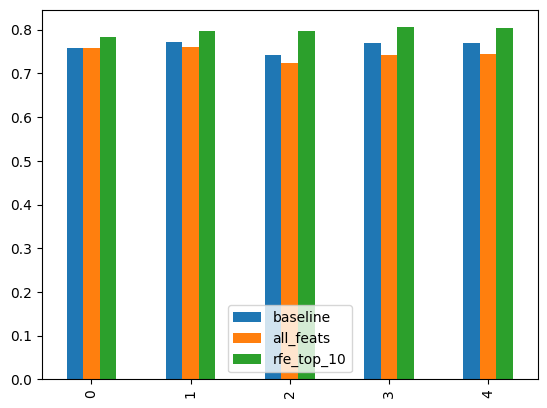

In [38]:
results_df.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")

### Decision Tree Classifier

In [39]:
from sklearn import tree

baseline_scores = cv_score(tree.DecisionTreeClassifier(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.6370602199157331, Recall Score: 0.4192, Precision Score: 0.3966,Acuuracy Score: 0.7742 

2 of kfold 5
ROC AUC Score: 0.6505396156612886, Recall Score: 0.4496, Precision Score: 0.4078,Acuuracy Score: 0.7770 

3 of kfold 5
ROC AUC Score: 0.6537925783151554, Recall Score: 0.4430, Precision Score: 0.4267,Acuuracy Score: 0.7865 

4 of kfold 5
ROC AUC Score: 0.6438317358927468, Recall Score: 0.4259, Precision Score: 0.4121,Acuuracy Score: 0.7810 

5 of kfold 5
ROC AUC Score: 0.6474831265541332, Recall Score: 0.4325, Precision Score: 0.4170,Acuuracy Score: 0.7828 


In [40]:
all_feat_scores = cv_score(tree.DecisionTreeClassifier())


1 of kfold 5
ROC AUC Score: 0.6457234611036893, Recall Score: 0.4363, Precision Score: 0.4066,Acuuracy Score: 0.7775 

2 of kfold 5
ROC AUC Score: 0.6566326174082828, Recall Score: 0.4601, Precision Score: 0.4162,Acuuracy Score: 0.7803 

3 of kfold 5
ROC AUC Score: 0.6583468463431, Recall Score: 0.4601, Precision Score: 0.4220,Acuuracy Score: 0.7831 

4 of kfold 5
ROC AUC Score: 0.6680938926677805, Recall Score: 0.4724, Precision Score: 0.4410,Acuuracy Score: 0.7912 

5 of kfold 5
ROC AUC Score: 0.6603108924178036, Recall Score: 0.4677, Precision Score: 0.4198,Acuuracy Score: 0.7815 


In [40]:
rfe_top_10_scores = cv_score(tree.DecisionTreeClassifier(), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.6702298838762717, Recall Score: 0.4667, Precision Score: 0.4567,Acuuracy Score: 0.7983 

2 of kfold 5
ROC AUC Score: 0.6401934025280033, Recall Score: 0.4240, Precision Score: 0.4018,Acuuracy Score: 0.7763 

3 of kfold 5
ROC AUC Score: 0.6651114371044772, Recall Score: 0.4686, Precision Score: 0.4351,Acuuracy Score: 0.7888 

4 of kfold 5
ROC AUC Score: 0.6778660189193101, Recall Score: 0.4781, Precision Score: 0.4705,Acuuracy Score: 0.8036 

5 of kfold 5
ROC AUC Score: 0.6689186522294, Recall Score: 0.4667, Precision Score: 0.4517,Acuuracy Score: 0.7962 


In [41]:
results_tree = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'rfe_top_10': rfe_top_10_scores})

<AxesSubplot: >

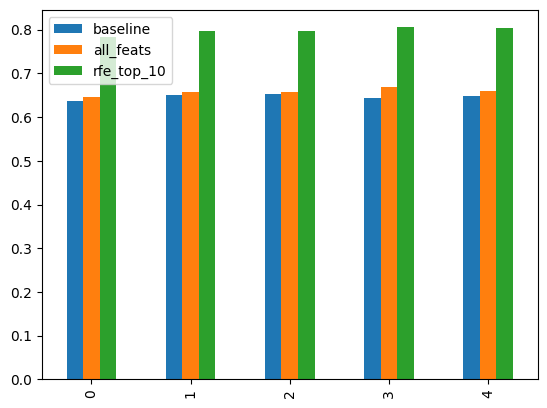

In [42]:
results_tree.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")

Here I haven't seen any improvement in value of accuracy & accuracy obtained much lesser than Logistic Regression.so, let us build another model i.e. Random Forest , a tree ensemble method and try to improve the accuracy

### Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier

baseline_scores = cv_score(RandomForestClassifier(max_depth=4), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7990198335217347, Recall Score: 0.3555, Precision Score: 0.7110,Acuuracy Score: 0.8538 

2 of kfold 5
ROC AUC Score: 0.8061644229781113, Recall Score: 0.3279, Precision Score: 0.6597,Acuuracy Score: 0.8441 

3 of kfold 5
ROC AUC Score: 0.8041742865788677, Recall Score: 0.3555, Precision Score: 0.6926,Acuuracy Score: 0.8513 

4 of kfold 5
ROC AUC Score: 0.807295195672767, Recall Score: 0.3489, Precision Score: 0.7224,Acuuracy Score: 0.8545 

5 of kfold 5
ROC AUC Score: 0.8043701978107279, Recall Score: 0.3441, Precision Score: 0.6766,Acuuracy Score: 0.8480 


In [44]:
all_feat_scores = cv_score(RandomForestClassifier(max_depth=4))


1 of kfold 5
ROC AUC Score: 0.806286918096804, Recall Score: 0.2091, Precision Score: 0.7458,Acuuracy Score: 0.8402 

2 of kfold 5
ROC AUC Score: 0.8099594080772787, Recall Score: 0.2177, Precision Score: 0.7134,Acuuracy Score: 0.8388 

3 of kfold 5
ROC AUC Score: 0.8124554934085019, Recall Score: 0.2395, Precision Score: 0.7590,Acuuracy Score: 0.8450 

4 of kfold 5
ROC AUC Score: 0.8195711003591775, Recall Score: 0.2624, Precision Score: 0.7954,Acuuracy Score: 0.8508 

5 of kfold 5
ROC AUC Score: 0.8116082235846698, Recall Score: 0.2804, Precision Score: 0.7338,Acuuracy Score: 0.8478 


In [45]:
rfe_top_10_scores = cv_score(RandomForestClassifier(max_depth=4), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.8092092282396464, Recall Score: 0.3346, Precision Score: 0.7364,Acuuracy Score: 0.8545 

2 of kfold 5
ROC AUC Score: 0.816018292056315, Recall Score: 0.3118, Precision Score: 0.6749,Acuuracy Score: 0.8446 

3 of kfold 5
ROC AUC Score: 0.8178262980712303, Recall Score: 0.3574, Precision Score: 0.7203,Acuuracy Score: 0.8552 

4 of kfold 5
ROC AUC Score: 0.8237747633441657, Recall Score: 0.3441, Precision Score: 0.7449,Acuuracy Score: 0.8566 

5 of kfold 5
ROC AUC Score: 0.8186514687791915, Recall Score: 0.3574, Precision Score: 0.7068,Acuuracy Score: 0.8534 


In [46]:
results_ensemble = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'rfe_top_10': rfe_top_10_scores})

<AxesSubplot: >

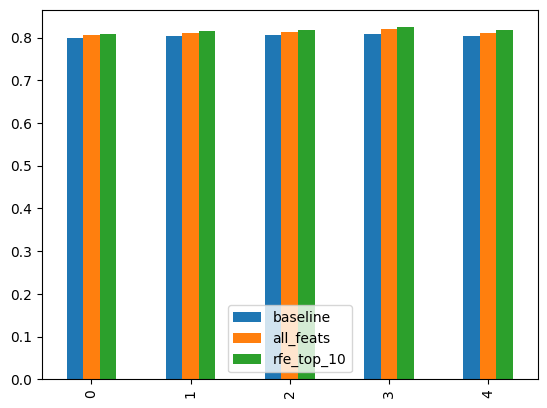

In [47]:
results_ensemble.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")

### Finding the right value of hyperparameters to improve the value of accuracy for Random Forest

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid={'max_depth':list(range(1,20,2)),'n_estimators':list(range(1,200,20))}
grid_search=GridSearchCV(RandomForestClassifier(random_state=15),param_grid)

In [ ]:
grid_search.fit(xtrain,ytrain)

In [56]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=101, random_state=15)

In [45]:
baseline_scores = cv_score(RandomForestClassifier(max_depth=9), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.8053696434076663, Recall Score: 0.3869, Precision Score: 0.7005,Acuuracy Score: 0.8557 

2 of kfold 5
ROC AUC Score: 0.8166141198232453, Recall Score: 0.3622, Precision Score: 0.6592,Acuuracy Score: 0.8471 

3 of kfold 5
ROC AUC Score: 0.8140652341231728, Recall Score: 0.3992, Precision Score: 0.6977,Acuuracy Score: 0.8566 

4 of kfold 5
ROC AUC Score: 0.8205935185246095, Recall Score: 0.3736, Precision Score: 0.7211,Acuuracy Score: 0.8571 

5 of kfold 5
ROC AUC Score: 0.8172970499427685, Recall Score: 0.3869, Precision Score: 0.6922,Acuuracy Score: 0.8545 


In [46]:
all_feat_scores = cv_score(RandomForestClassifier(max_depth=9))


1 of kfold 5
ROC AUC Score: 0.8252395437262358, Recall Score: 0.3593, Precision Score: 0.7456,Acuuracy Score: 0.8586 

2 of kfold 5
ROC AUC Score: 0.8338355770218888, Recall Score: 0.3498, Precision Score: 0.7146,Acuuracy Score: 0.8536 

3 of kfold 5
ROC AUC Score: 0.8293399374399727, Recall Score: 0.3850, Precision Score: 0.7514,Acuuracy Score: 0.8624 

4 of kfold 5
ROC AUC Score: 0.8380200590077229, Recall Score: 0.3764, Precision Score: 0.7543,Acuuracy Score: 0.8617 

5 of kfold 5
ROC AUC Score: 0.8354753715118346, Recall Score: 0.3869, Precision Score: 0.7427,Acuuracy Score: 0.8615 


In [49]:
rfe_top_10_scores = cv_score(RandomForestClassifier(max_depth=9), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.8283211386291235, Recall Score: 0.4202, Precision Score: 0.7258,Acuuracy Score: 0.8631 

2 of kfold 5
ROC AUC Score: 0.8332039872572192, Recall Score: 0.4154, Precision Score: 0.7003,Acuuracy Score: 0.8587 

3 of kfold 5
ROC AUC Score: 0.8341156077729682, Recall Score: 0.4363, Precision Score: 0.7286,Acuuracy Score: 0.8654 

4 of kfold 5
ROC AUC Score: 0.8409003447050929, Recall Score: 0.4287, Precision Score: 0.7442,Acuuracy Score: 0.8668 

5 of kfold 5
ROC AUC Score: 0.8402908202533977, Recall Score: 0.4392, Precision Score: 0.7404,Acuuracy Score: 0.8675 


In [50]:
results_ensemble = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'rfe_top_10': rfe_top_10_scores})

<AxesSubplot: >

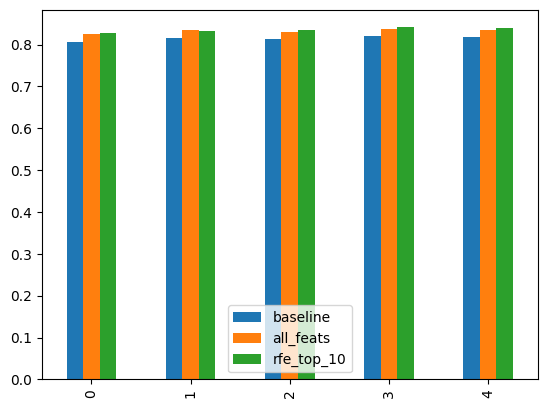

In [51]:
results_ensemble.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")